In [29]:
#!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller  
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from pmdarima.arima import auto_arima
%matplotlib inline
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.simplefilter(action="ignore")
import math


In [37]:
def test_stationarity(timeseries, window=365):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < 0.05:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [38]:
df = pd.read_csv('./data/MSFT_stock_data.csv')

In [39]:
df.head()

,1. open,2. high,3. low,4. close,5. volume,IWO_5d_EMA,IWO_10d_EMA,IWO_150d_EMA,EMA_8,EMA_21,SMA_50,SMA_200
2021-01-20,217.700,225.790,217.291,224.340,37777260.000,310.587,305.966,247.205,219.388,219.488,218.474,205.435
2021-01-19,213.750,216.980,212.630,216.440,30480859.000,308.605,304.059,246.301,217.559,218.858,218.429,205.087
2021-01-15,213.520,214.510,212.030,212.650,31746512.000,306.332,302.039,245.404,217.724,219.046,218.444,204.773
2021-01-14,215.910,217.460,212.740,213.020,29346737.000,305.923,300.903,244.575,218.643,219.500,218.306,204.483
2021-01-13,214.020,216.760,213.927,216.340,20087080.000,302.995,298.486,243.673,218.980,219.704,218.051,204.214


In [40]:
df = df.sort_index()

In [41]:
df.index = pd.to_datetime(df.index)

In [42]:
series = df[['4. close']]

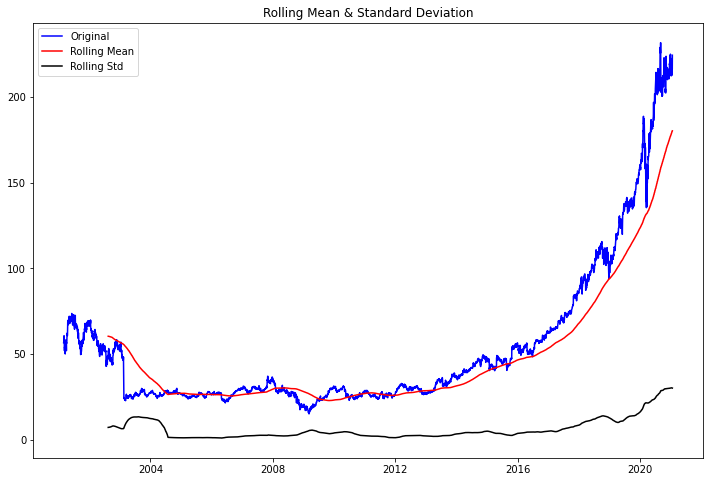

Results of Dickey-Fuller Test:
p-value = 1.0000. The series is likely non-stationary.
Test Statistic                   3.694
p-value                          1.000
#Lags Used                      16.000
Number of Observations Used   4986.000
Critical Value (1%)             -3.432
Critical Value (5%)             -2.862
Critical Value (10%)            -2.567
dtype: float64


In [43]:
test_stationarity(series)

In [44]:
series_diff = series.diff()
series_diff = series_diff.dropna()

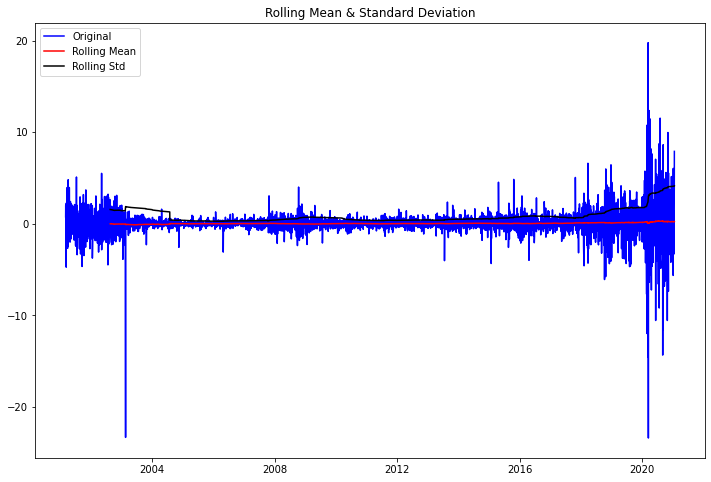

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                 -14.935
p-value                          0.000
#Lags Used                      20.000
Number of Observations Used   4981.000
Critical Value (1%)             -3.432
Critical Value (5%)             -2.862
Critical Value (10%)            -2.567
dtype: float64


In [45]:
test_stationarity(series_diff)

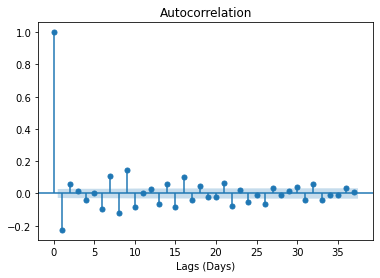

In [46]:
plot_acf(series_diff)
plt.xlabel('Lags (Days)')
plt.show()


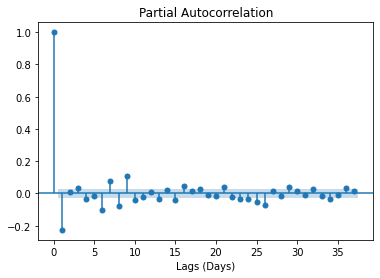

In [47]:
plot_pacf(series_diff)
plt.xlabel('Lags (Days)')
plt.show()

In [48]:
print(f'Number of observations: {len(series)}')
print(f'Number of training observations: {round(len(series) * 0.90)}')
print(f'Number of testing observations: {len(series) - round(len(series) * 0.90)}')

Number of observations: 5003
Number of training observations: 4503
Number of testing observations: 500


In [49]:
plot_axis = len(series)
plot_axis

5003

In [50]:
split_index = round(len(series) * 0.90) +1
split_index

4504

In [51]:
train = series.iloc[:split_index,]
test = series.iloc[split_index:,]

In [52]:
index_ = [pd.to_datetime(date, format='%Y').date() 
        for date in pd.date_range(df.index[0], df.index[-1], freq="Y")]

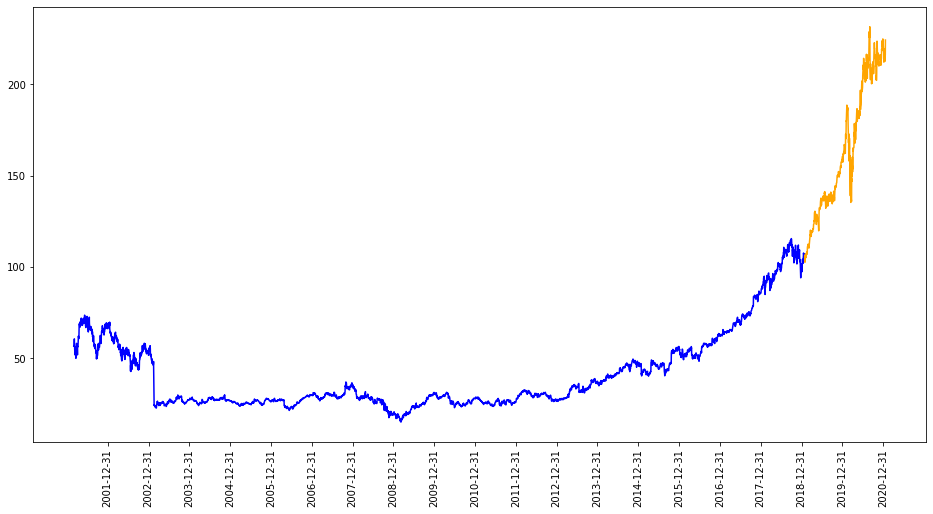

In [53]:
plt.figure(figsize=(16, 8))
plt.plot(train, c='blue')
plt.plot(test, c='orange')
plt.xticks(index_, rotation = 90);

In [54]:
model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11658.145, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11629.151, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11625.991, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11656.813, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11619.649, Time=0.69 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11621.210, Time=0.77 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11621.068, Time=0.93 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11619.638, Time=0.36 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=11621.393, Time=0.56 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=11623.055, Time=2.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=11618.530, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=11624.809, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=11619.942, Time=0.42 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=11620.271, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0

In [55]:
model_autoARIMA.order

(0, 1, 2)

In [56]:
print(model_autoARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4504
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -5806.265
Date:                Thu, 21 Jan 2021   AIC                          11618.530
Time:                        16:42:34   BIC                          11637.768
Sample:                             0   HQIC                         11625.308
                               - 4504                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0864      0.007    -11.845      0.000      -0.101      -0.072
ma.L2         -0.0443      0.009     -5.107      0.000      -0.061      -0.027
sigma2         0.7718      0.002    343.108      0.0

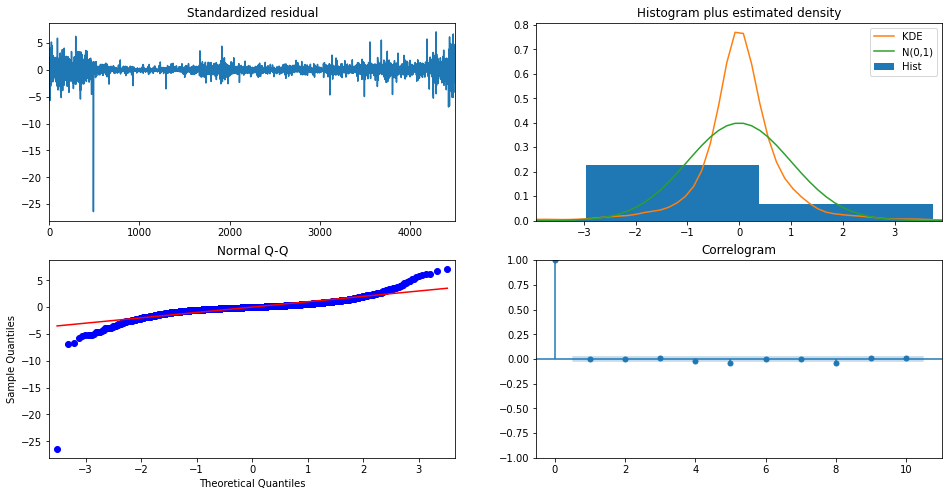

In [57]:
model_autoARIMA.plot_diagnostics(figsize = (16, 8))
plt.show()

Interpretting the residual plots from autoARIMA

- Standardized Residual - Massive increase in variance as we move right 
- Histogram shows that we have a normal distirbution 
- Distribution appears skewed at the ends
- ACF plot shows little pattern in residual errors

In [58]:
model = ARIMA(train, order = model_autoARIMA.order)
fitted = model.fit(disp = -1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.4. close   No. Observations:                 4503
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -5805.819
Method:                       css-mle   S.D. of innovations              0.878
Date:                Thu, 21 Jan 2021   AIC                          11619.638
Time:                        16:42:52   BIC                          11645.288
Sample:                             1   HQIC                         11628.675
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0107      0.011      0.945      0.345      -0.012       0.033
ma.L1.D.4. close    -0.0867      0.015     -5.806      0.000      -0.116      -0.057
ma.L2.D.4. close    -0.0445 

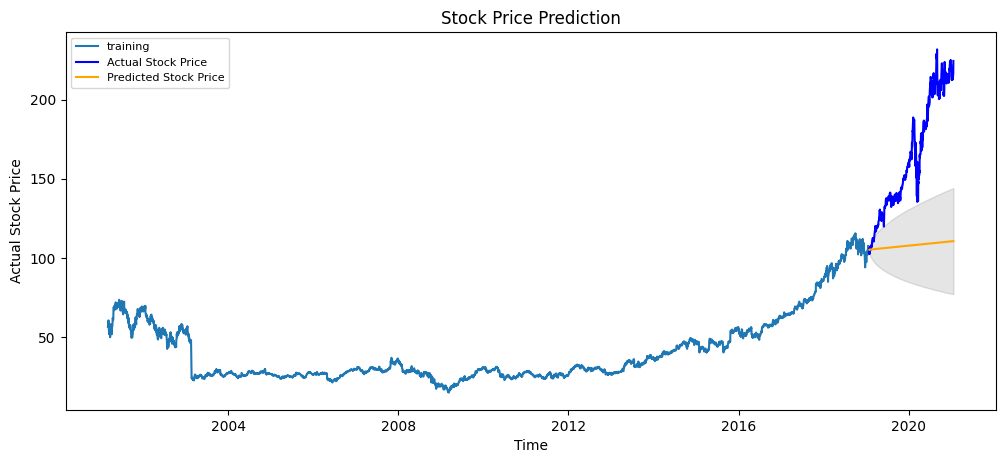

In [59]:
# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [60]:
fc_series.max()

110.66878989948572

In [61]:
# report performance
mse = mean_squared_error(test, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test, fc))
print('RMSE: '+str(rmse))


MSE: 4475.690009337363
MAE: 57.20190438934572
RMSE: 66.90059797443789


In [62]:
plot_axis = len(series_diff)
split_index = round(len(series_diff) * 0.75) +1
train = series_diff.iloc[:split_index,]
test = series_diff.iloc[split_index:,]

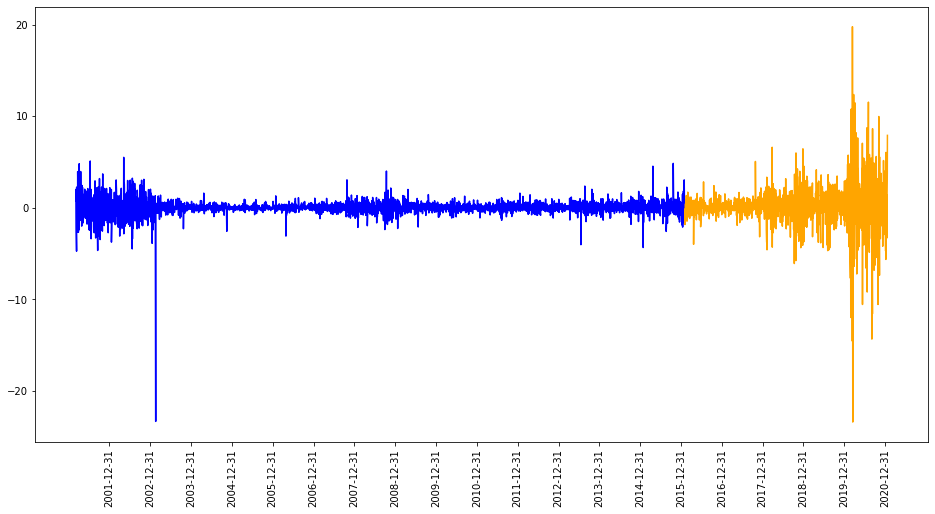

In [63]:
plt.figure(figsize=(16, 8))
plt.plot(train, c='blue')
plt.plot(test, c='orange')
plt.xticks(index_, rotation=90);

In [64]:
model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8995.873, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8988.182, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8987.618, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8984.841, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8986.795, Time=0.31 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8986.795, Time=0.36 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=8986.808, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8987.203, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8988.841, Time=0.36 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8986.830, Time=0.91 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 2.643 seconds


In [65]:
print(model_autoARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3753
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -4489.421
Date:                Thu, 21 Jan 2021   AIC                           8984.841
Time:                        16:43:36   BIC                           9003.532
Sample:                             0   HQIC                          8991.488
                               - 3753                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5800      0.104      5.601      0.000       0.377       0.783
ma.L1         -0.6317      0.100     -6.335      0.000      -0.827      -0.436
sigma2         0.6405      0.002    381.034      0.0

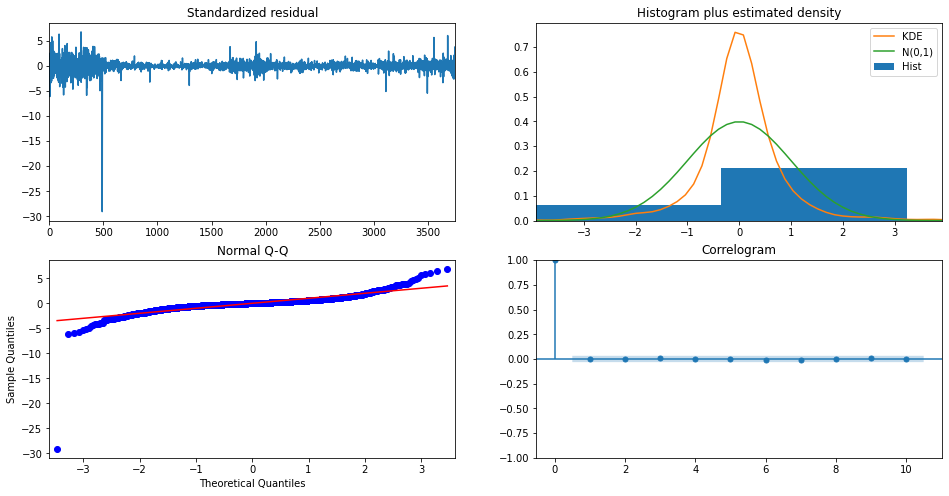

In [66]:
model_autoARIMA.plot_diagnostics(figsize = (16, 8))
plt.show()

In [67]:
model = ARIMA(train, model_autoARIMA.order)
fitted = model.fit(disp = -1)
print(fitted.summary())

                              ARMA Model Results                              
Dep. Variable:               4. close   No. Observations:                 3753
Model:                     ARMA(1, 1)   Log Likelihood               -4489.415
Method:                       css-mle   S.D. of innovations              0.800
Date:                Thu, 21 Jan 2021   AIC                           8986.830
Time:                        16:43:42   BIC                           9011.751
Sample:                             0   HQIC                          8995.693
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0012      0.011     -0.106      0.916      -0.024       0.021
ar.L1.4. close     0.5794      0.146      3.963      0.000       0.293       0.866
ma.L1.4. close    -0.6311      0.139

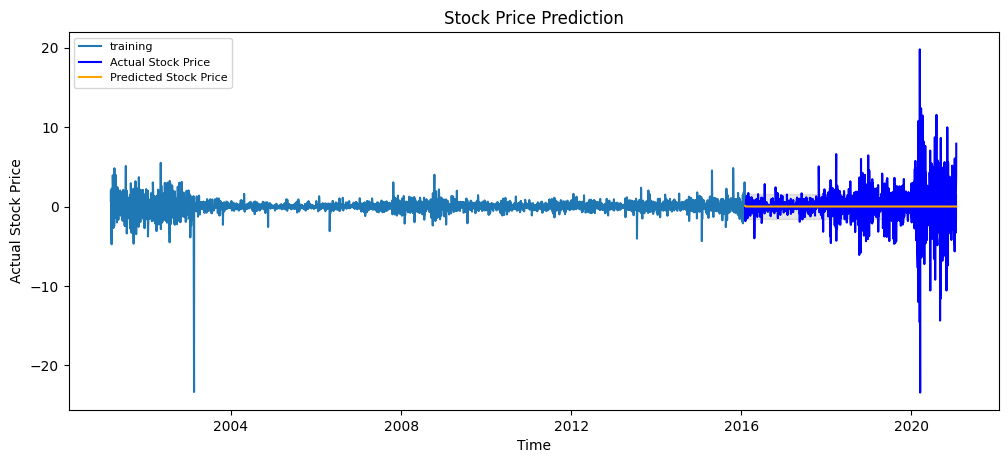

In [68]:
# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [69]:
# report performance
mse = mean_squared_error(test, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test, fc))
print('RMSE: '+str(rmse))

MSE: 6.115967495900375
MAE: 1.412057498133661
RMSE: 2.4730482194854946
